### Predicting Dota 2 Draft Strength Using Keras. 

#### Using Team Input we will try to predict which team has a better draft.

#### Loading Libraries.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense, Activation, Add, LSTM, Embedding
from tensorflow.python.keras.models import Model
from matplotlib import pyplot
import warnings; warnings.simplefilter('ignore')
tf.reset_default_graph()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Import Data as Pandas Dataframe Object.

In [2]:
Dota_2_DF = pd.read_csv('Dota_2_Model_Data.csv')

In [3]:
print(Dota_2_DF.shape)

(108800, 17)


#### View Dataframe.

In [4]:
Dota_2_DF.head(1)

,Unnamed: 0,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,Kills,Deaths,Assists,Last_Hits,Denies,GPM,XPM,Networth,XP,Win/Loss,Duration
0,0,34,63,83,67,97,39,48,79,1499,17,2312,2824,122085,181281,5,3647


#### Taking 50000 matches data and defining model variables and label.

In [5]:
Dota_2_DF = Dota_2_DF.head(100000)
# Select Rows with Even Indices
Team_1 = Dota_2_DF.iloc[::2]
# Select Rows with Odd Indices
Team_2 = Dota_2_DF.iloc[1::2]
Label_Data = Team_1[['Win/Loss']]
Label_Data = Label_Data.values
Label_Data[Label_Data >= 1] = 1
Team_1 = Team_1[['Hero_1', 'Hero_2', 'Hero_3', 'Hero_4', 'Hero_5']]
Team_2 = Team_2[['Hero_1', 'Hero_2', 'Hero_3', 'Hero_4', 'Hero_5']]
Team_1 = Team_1.values
Team_2 = Team_2.values

#### Shuffling the entire dataset to disrupt the order of matches according to time to prevent any bias.

#### As the dataset has recorded all matches between a duration of an hour and we need our model to have data for any time and not skewed towards the eary or later part of the hour.

In [6]:
Permutation = np.random.permutation(Team_1.shape[0])
Team_1 = Team_1[Permutation]
Team_2 = Team_2[Permutation]
Label_Data = Label_Data[Permutation]

#### Training & Testing Data - Hero ID.

In [7]:
Training_Team_1 = Team_1[:40000]
Training_Team_2 = Team_2[:40000]
Train_L = Label_Data[:40000]

Testing_Team_1 = Team_1[40000:]
Testing_Team_2 = Team_2[40000:]
Test_L = Label_Data[40000:]

print(Training_Team_1[0])
print(Training_Team_2[0])
print(Testing_Team_1[0])
print(Testing_Team_2[0])
print(Train_L[0])
print(Test_L[0])

[114  22  78  88  11]
[  9  81  34 118   3]
[ 80  79 109  12  71]
[ 40  70 102 113   8]
[1]
[1]


#### Label = 1 Means Team 1 Won and Label = 0 Means Team 2 Won.

### Team Heroes Input Feed Forward Network.

In [8]:
Initializer = tf.keras.initializers.glorot_normal()
T_1 = Input(shape=(5,))
Team_1 = Dense(64, activation='relu', kernel_initializer= Initializer)(T_1)
T_2 = Input(shape=(5,))
Team_2 = Dense(64, activation='relu', kernel_initializer= Initializer)(T_2)

Merged = Add()([Team_1, Team_2])
Layer_1 = Dense(32, activation='sigmoid', kernel_initializer= Initializer)(Merged)

Output = Dense(1, activation='sigmoid')(Layer_1)
Model_T = Model(inputs=[T_1, T_2], outputs=Output)
Model_T.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           384         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           384         input_2[0][0]                    
__________________________________________________________________________________________________
add (Add) 

In [9]:
Batch_Size = 128
Model_T.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
Model_History = Model_T.fit([Training_Team_1, Training_Team_2], Train_L, epochs=5, verbose = 1, batch_size= Batch_Size, validation_data =([Testing_Team_1, Testing_Team_2], Test_L))

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 6s 139us/step - loss: 0.6928 - acc: 0.5189 - val_loss: 0.6908 - val_acc: 0.5288
Epoch 2/5
40000/40000 [==============================] - 2s 52us/step - loss: 0.6914 - acc: 0.5255 - val_loss: 0.6906 - val_acc: 0.5287
Epoch 3/5
40000/40000 [==============================] - 2s 53us/step - loss: 0.6910 - acc: 0.5261 - val_loss: 0.6900 - val_acc: 0.5369
Epoch 4/5
40000/40000 [==============================] - 2s 52us/step - loss: 0.6909 - acc: 0.5306 - val_loss: 0.6904 - val_acc: 0.5286
Epoch 5/5
40000/40000 [==============================] - 2s 52us/step - loss: 0.6908 - acc: 0.5266 - val_loss: 0.6902 - val_acc: 0.5317


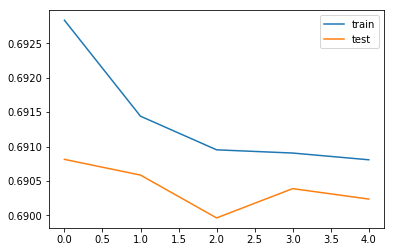

In [10]:
pyplot.plot(Model_History.history['loss'], label='train')
pyplot.plot(Model_History.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

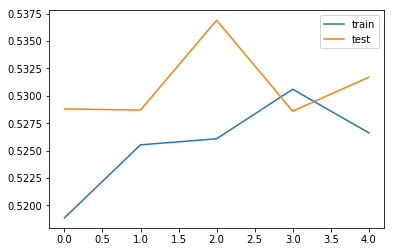

In [11]:
pyplot.plot(Model_History.history['acc'], label='train')
pyplot.plot(Model_History.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### Team Heroes Input Long Short Term Memory Network.

In [12]:
Initializer = tf.keras.initializers.glorot_normal()
T_1 = Input(shape=(5,), dtype='int32', name='Team_1')
T_2 = Input(shape=(5,), dtype='int32', name='Team_2')

Emb = Embedding(input_dim=125, output_dim=32, input_length=5)
Emb_T1= Emb(T_1)
Emb_T2 = Emb(T_2)

LSTM_Team = LSTM(32, input_shape=(1,32))

Emb_LSTM_1 = LSTM_Team(Emb_T1)
Emb_LSTM_2 = LSTM_Team(Emb_T2)

Merged = Add()([Emb_LSTM_1, Emb_LSTM_2])
Layer_1 = Dense(32, activation='tanh', kernel_initializer= Initializer)(Merged)

Output = Dense(1, activation='sigmoid')(Layer_1)
Model_T = Model(inputs=[T_1, T_2], outputs=Output)
Model_T.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team_1 (InputLayer)             (None, 5)            0                                            
__________________________________________________________________________________________________
Team_2 (InputLayer)             (None, 5)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 32)        4000        Team_1[0][0]                     
                                                                 Team_2[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           8320        embedding[0][0]                  
          

In [13]:
Batch_Size = 128
Model_T.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
Model_History = Model_T.fit([Training_Team_1, Training_Team_2], Train_L, epochs=5, verbose = 1, batch_size= Batch_Size, validation_data =([Testing_Team_1, Testing_Team_2], Test_L))

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 15s 373us/step - loss: 0.6944 - acc: 0.5165 - val_loss: 0.6922 - val_acc: 0.5239
Epoch 2/5
40000/40000 [==============================] - 11s 285us/step - loss: 0.6932 - acc: 0.5151 - val_loss: 0.6923 - val_acc: 0.5305
Epoch 3/5
40000/40000 [==============================] - 11s 284us/step - loss: 0.6925 - acc: 0.5218 - val_loss: 0.6925 - val_acc: 0.5195
Epoch 4/5
40000/40000 [==============================] - 11s 285us/step - loss: 0.6920 - acc: 0.5238 - val_loss: 0.6925 - val_acc: 0.5305
Epoch 5/5
40000/40000 [==============================] - 11s 285us/step - loss: 0.6915 - acc: 0.5255 - val_loss: 0.6920 - val_acc: 0.5273


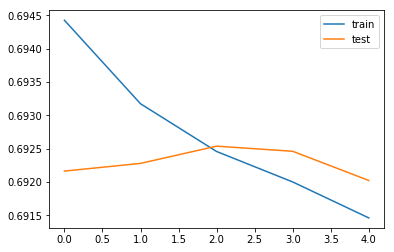

In [14]:
pyplot.plot(Model_History.history['loss'], label='train')
pyplot.plot(Model_History.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

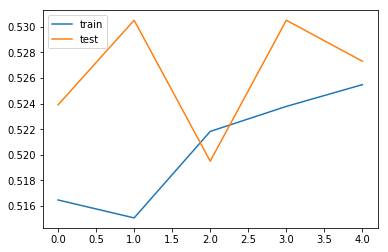

In [15]:
pyplot.plot(Model_History.history['acc'], label='train')
pyplot.plot(Model_History.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### Team Heroes Input Long Short Term Memory Network With Feed Forward Network.

In [16]:
Initializer = tf.keras.initializers.glorot_normal()
T_1 = Input(shape=(5,), dtype='int32', name='Team_1')
T_2 = Input(shape=(5,), dtype='int32', name='Team_2')

Emb = Embedding(input_dim=125, output_dim=32, input_length=5)
Emb_T1= Emb(T_1)
Emb_T2 = Emb(T_2)

LSTM_Team = LSTM(32, input_shape=(1,32))

Emb_LSTM_1 = LSTM_Team(Emb_T1)
Team_1_FFNN = Dense(32, activation='tanh', kernel_initializer= Initializer)(Emb_LSTM_1)

Emb_LSTM_2 = LSTM_Team(Emb_T2)
Team_2_FFNN = Dense(32, activation='tanh', kernel_initializer= Initializer)(Emb_LSTM_1)

Merged = Add()([Team_1_FFNN, Team_2_FFNN])
Layer_1 = Dense(32, activation='tanh', kernel_initializer= Initializer)(Merged)

Output = Dense(1, activation='sigmoid')(Layer_1)
Model_T = Model(inputs=[T_1, T_2], outputs=Output)
Model_T.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team_1 (InputLayer)             (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 32)        4000        Team_1[0][0]                     
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           8320        embedding_1[0][0]                
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 32)           1056        lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_7 (D

In [17]:
Batch_Size = 64
Model_T.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
Model_History = Model_T.fit([Training_Team_1, Training_Team_2], Train_L, epochs=5, verbose = 1, batch_size= Batch_Size, validation_data =([Testing_Team_1, Testing_Team_2], Test_L))

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 19s 463us/step - loss: 0.6882 - acc: 0.5360 - val_loss: 0.6818 - val_acc: 0.5634
Epoch 2/5
40000/40000 [==============================] - 18s 442us/step - loss: 0.6818 - acc: 0.5630 - val_loss: 0.6762 - val_acc: 0.5713
Epoch 3/5
40000/40000 [==============================] - 16s 394us/step - loss: 0.6803 - acc: 0.5652 - val_loss: 0.6755 - val_acc: 0.5730
Epoch 4/5
40000/40000 [==============================] - 16s 396us/step - loss: 0.6797 - acc: 0.5686 - val_loss: 0.6764 - val_acc: 0.5747
Epoch 5/5
40000/40000 [==============================] - 16s 394us/step - loss: 0.6791 - acc: 0.5699 - val_loss: 0.6770 - val_acc: 0.5729


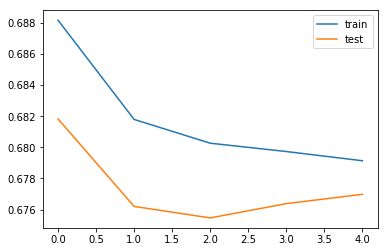

In [18]:
pyplot.plot(Model_History.history['loss'], label='train')
pyplot.plot(Model_History.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

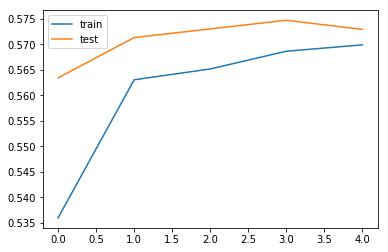

In [19]:
pyplot.plot(Model_History.history['acc'], label='train')
pyplot.plot(Model_History.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

#### Lets see what the latest model has to say on my past match, I had lost this game. I am using the hero lookup table to obtain hero id for all the heroes that were played in this match.

In [20]:
My_Team = np.asarray([[8, 36, 119, 27, 75]])
Enemy_Team = np.asarray([[17, 20, 71, 47, 109]])
Draft_Strength = Model_T.predict([My_Team, Enemy_Team], batch_size=None, verbose=0, steps=None)
print('My Team Strength: '+ str(Draft_Strength[0][0]*100) + '%')
print('Enemy Team Strength: '+ str(100 - Draft_Strength[0][0]*100) + '%')

My Team Strength: 49.75258409976959%
Enemy Team Strength: 50.24741590023041%
